In [1]:
import urllib.request
from utils import *

sns.set_style("whitegrid")
# Downloading files
urls = {
    'application_record': 'https://raw.githubusercontent.com/aspagnuolo/Creditworthiness/main/credit_card_approval/application_record.csv',
    'credit_record': 'https://raw.githubusercontent.com/aspagnuolo/Creditworthiness/main/credit_card_approval/credit_record.csv'
}

for name, url in urls.items():
    urllib.request.urlretrieve(url, f"{name}.csv")

# Loading data from CSV files
application_df = pd.read_csv('application_record.csv')
credit_record_df = pd.read_csv('credit_record.csv')

**DATA LABELING**

In [2]:

# We explore the distribution of payment states in the credit_record dataset
status_distribution = round(credit_record_df['STATUS'].value_counts(normalize=True) * 100, 2)

# Grouping data by MONTHS_BALANCE and STATUS to get counts
status_counts = credit_record_df.groupby(['MONTHS_BALANCE', 'STATUS']).size().unstack().fillna(0)
status_counts = status_counts.sort_index(ascending=False)

<Figure size 1400x1000 with 0 Axes>

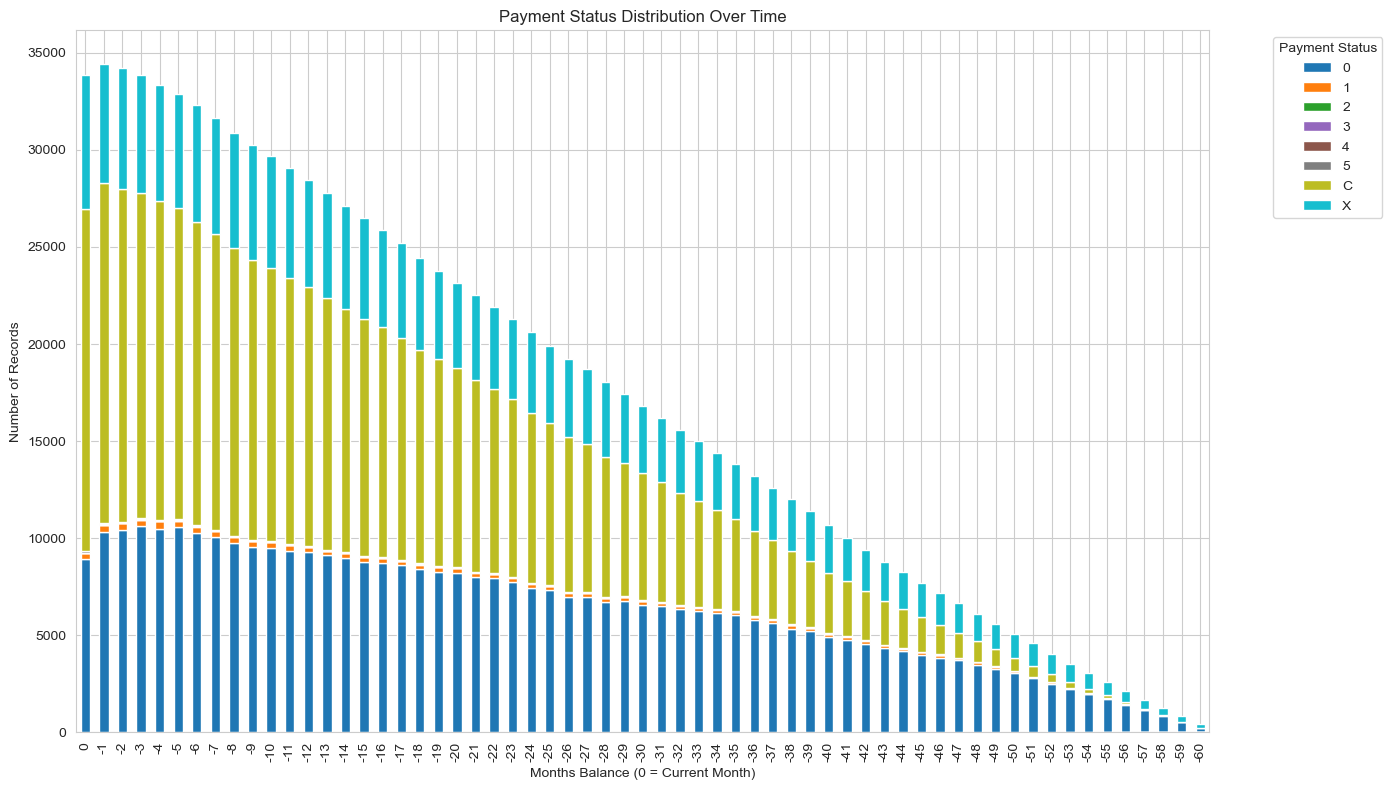

In [3]:
plot_status_distribution(status_counts)

From the graph, we can see that the number of clients tends to decrease as we move back in time. This might suggest that the dataset has more recent data than past data, or that many customers have only recently joined the system.

From the visualization of client seniority and STATUS distribution, we can make some observations:
- Recent vs. Older: We have more data on recent clients than on older clients. This means we may have a clearer view of their recent credit history.
- Payment status: Most customers have paid their debt on time, but there are also customers who have shown varying degrees of late payment.
To determine "good" and "bad" customers in a balanced way, we could adopt the following strategies:

**- Initial Classification**

If, in the past 6 months, a customer has had severe delays (status "2", "3", "4", or "5"), they are classified as "bad".
If a customer has had no delays or only minor delays (status "0" or "1") in the past 6 months, it is classified as "good."
All other clients are classified as "intermediate."

The choice of the last 6 months was made based on several considerations:

Temporal Relevance: More recent information is often more relevant when assessing customer behavior, especially in the credit arena. 

Sample Size: Selecting a 6-month period provides a reasonably large sample size to make an assessment, but not too long to dilute recent information that might be more relevant.

Industry Standards: Many lending institutions use similar time windows (e.g., 3, 6, or 12 months) to monitor and assess customer payment behavior.

Avoiding Seasonal Variations: Using a 6-month period reduces the effect of seasonal variations that could affect payment behavior (e.g., vacations or vacation periods).

**- Refining intermediate customers**

The strategy adopted focuses on classifying intermediate customers based on their recent payment behavior. More specifically:

Classification as "bad" based on payments in the past 6 months: If a customer has had late payments between 30 and 59 days (status "1") 2 or more times in the past 6 months.

Default classification as "good": All other intermediate customers, who do not meet the above conditions, are classified as "good." In the absence of clear signs of risk, it is prudent to give customers the benefit of the doubt and classify them as low risk.

In [4]:
credit_record_sorted = credit_record_df.sort_values(by=['ID', 'MONTHS_BALANCE'], ascending=[True, False])
customer_classifications = credit_record_sorted.groupby('ID')['STATUS'].apply(classify_customer)

intermediate_indices = customer_classifications[customer_classifications == 'intermediate'].index
refined_intermediate_classifications_v3 = credit_record_sorted[credit_record_sorted['ID'].isin(intermediate_indices)].groupby('ID')['STATUS'].apply(refine_intermediate_classification_v3)
customer_classifications.loc[intermediate_indices] = refined_intermediate_classifications_v3
customer_classifications.value_counts()

STATUS
good    45546
bad       439
Name: count, dtype: int64

In [5]:
# Convert classifications to DataFrame
binary_df = customer_classifications.reset_index()
binary_df.columns = ['ID', 'Credit_Risk']
binary_df['Credit_Risk'] = binary_df['Credit_Risk'].replace({'good': 0, 'bad': 1})

# Perform the inner join
final_df = pd.merge(binary_df, application_df, on='ID', how='inner')

# Convert days to years for age and employment duration
final_df['AGE'] = (-final_df['DAYS_BIRTH'] / 365).astype(int)
final_df['YEARS_EMPLOYED'] = final_df['DAYS_EMPLOYED'].apply(lambda x: -x / 365 if x < 0 else np.nan)
final_df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'], inplace=True)

final_df.head()

,ID,Credit_Risk,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED
0,5008804,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,32,12.443836
1,5008805,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,32,12.443836
2,5008806,0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,58,3.106849
3,5008808,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8.358904
4,5008809,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8.358904


**NaN values**

In [6]:
nan_values_before = count_nan_values(final_df)
print("NaN counts before imputation:", nan_values_before)

NaN counts before imputation: OCCUPATION_TYPE    11323
YEARS_EMPLOYED      6135
dtype: int64


let's try to check what the nan of YEARS_EMPLOYED correspond to in NAME_INCOME_TYPE 

In [7]:
nan_years_employed_income_type = filter_nan_years(final_df)
print("Income types associated with NaN years employed:", nan_years_employed_income_type)

Income types associated with NaN years employed: NAME_INCOME_TYPE
Pensioner    6135
Name: count, dtype: int64


all missing values in the YEARS_EMPLOYED column are associated with customers who have NAME_INCOME_TYPE as " Pensioner". Since they are retired, we can assume that they are not currently employed. Therefore, we could impute these missing values with zero, indicating that they do not have years of current employment.

In [8]:
# Impute NaN values in YEARS_EMPLOYED column with 0
final_df['YEARS_EMPLOYED'].fillna(0, inplace=True)

We assign the nan of OCCUPATION_TYPE to a new category that we call "Not Specified".

In [9]:
# Imputing NaN values in the OCCUPATION_TYPE column with "Not Specified"
final_df['OCCUPATION_TYPE'].fillna('Not Specified', inplace=True)

# Verifying that there are no more NaN values in the DataFrame
nan_values_after = count_nan_values(final_df)
print("NaN counts after imputation:", nan_values_after)

NaN counts after imputation: Series([], dtype: int64)


**EDA (Exploratory Data Analysis)**

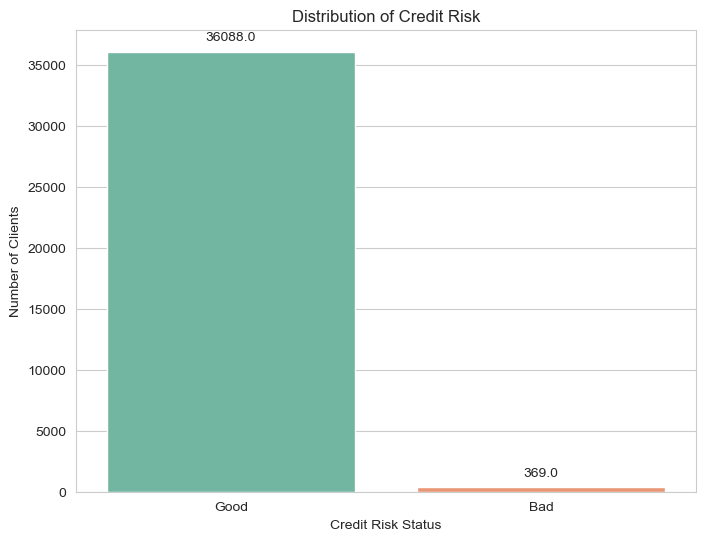

In [10]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x='Credit_Risk', data=final_df, palette="Set2")

plt.xlabel("Credit Risk Status")
plt.ylabel("Number of Clients")
plt.title('Distribution of Credit Risk')
plt.xticks(ticks=[0, 1], labels=['Good', 'Bad'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.show()

a significant majority of the entries are labeled as having low credit risk (Credit_Risk = 0), while a smaller portion is labeled as having high credit risk (Credit_Risk = 1).
This indicates that we're dealing with an imbalanced dataset, which is something to consider when building and evaluating machine learning models.

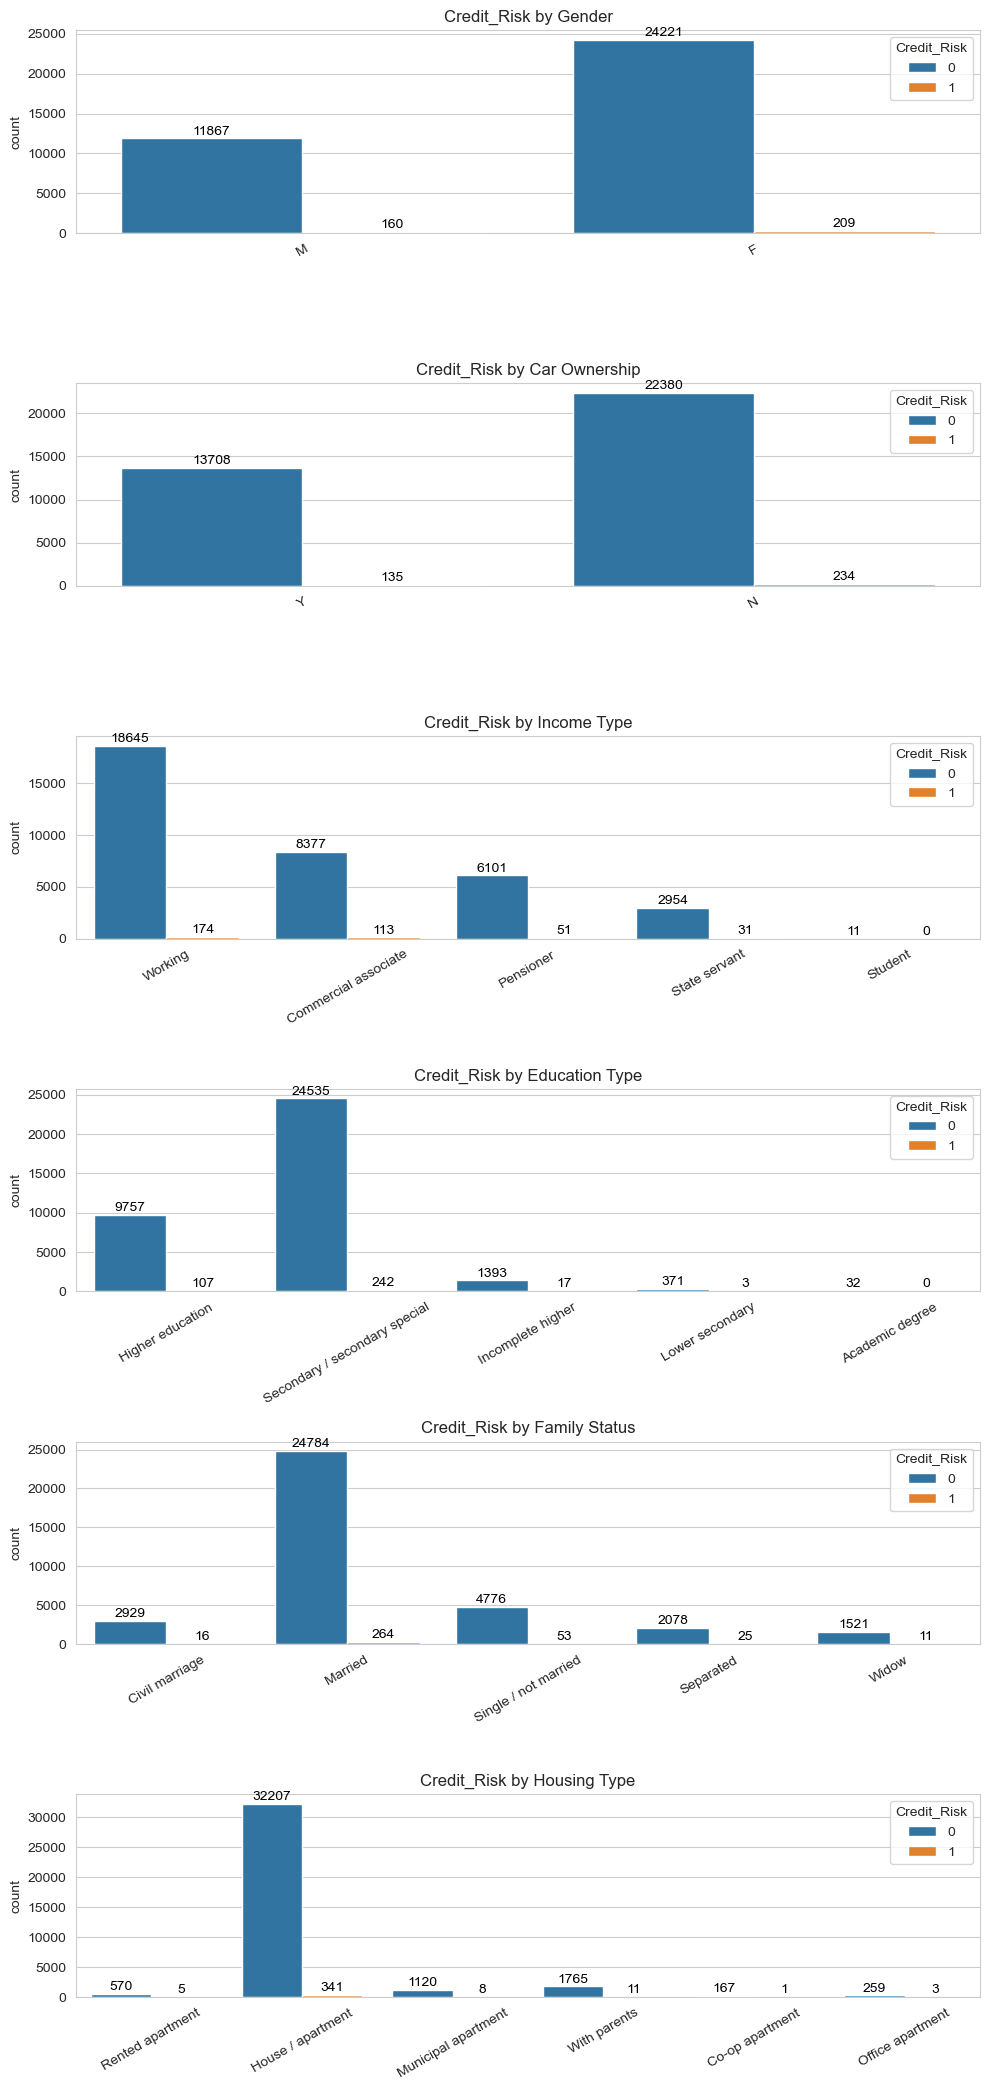

In [11]:
# Visualizing the relationship between categorical features and Credit_Risk
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 21))

plot_data = [
    ('CODE_GENDER', 'Credit_Risk by Gender', []),
    ('FLAG_OWN_CAR', 'Credit_Risk by Car Ownership', []),
    ('NAME_INCOME_TYPE', 'Credit_Risk by Income Type', []),
    ('NAME_EDUCATION_TYPE', 'Credit_Risk by Education Type', []),
    ('NAME_FAMILY_STATUS', 'Credit_Risk by Family Status', []),
    ('NAME_HOUSING_TYPE', 'Credit_Risk by Housing Type', [])
]

for i, (column, title, xlabels) in enumerate(plot_data):
    ax = sns.countplot(x=column, hue='Credit_Risk', data=final_df, ax=axes[i])
    axes[i].set_title(title)
    if xlabels:
        axes[i].set_xticklabels(xlabels)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=30)

    # Add labels with the number
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=10, color='black', 
                    xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()


**Credit_Risk by Gender (CODE_GENDER):**

Both genders have a higher count of individuals not considered a credit risk (Credit_Risk = 0).
However, the ratio of credit risks to non-credit risks appears slightly higher for males compared to females.

**Credit_Risk by Car Ownership (FLAG_OWN_CAR):**

Individuals who do not own a car have a slightly higher count of being labeled as a credit risk. However, the difference isn't substantial.

**Credit_Risk by Income Type (NAME_INCOME_TYPE):**

"Commercial associate" and "state servant" have slightly higher risk percentages; it is critical to consider both the absolute number and the risk percentage when making decisions based on this data.

**Credit_Risk by Education Type  (NAME_EDUCATION_TYPE)**
Those with incomplete education have the highest credit risk, while those with an academic degree have no risk. Individuals with lower secondary education have the lowest credit risk among the categories with non-zero risk.

**Credit_Risk by Family Status (NAME_FAMILY_STATUS)**
The category with the highest percentage of credit risk is "Separated," with 1.19 percent, followed by "Single/unmarried" with 1.10 percent. However, it is important to note that the absolute number of people with credit risk in these categories is relatively low compared to the "Married" category.

**Credit_Risk by House Type (NAME_HOUSING_TYPE)**
"Office Apartments" has the highest percentage of credit risk at 1.15 percent, but again, the absolute number is low. The "House/Apartment" category has the highest number of people with credit risk (341 people), but the percentage is comparable to other categories, such as "Rental Apartment" and "Municipal Apartment."

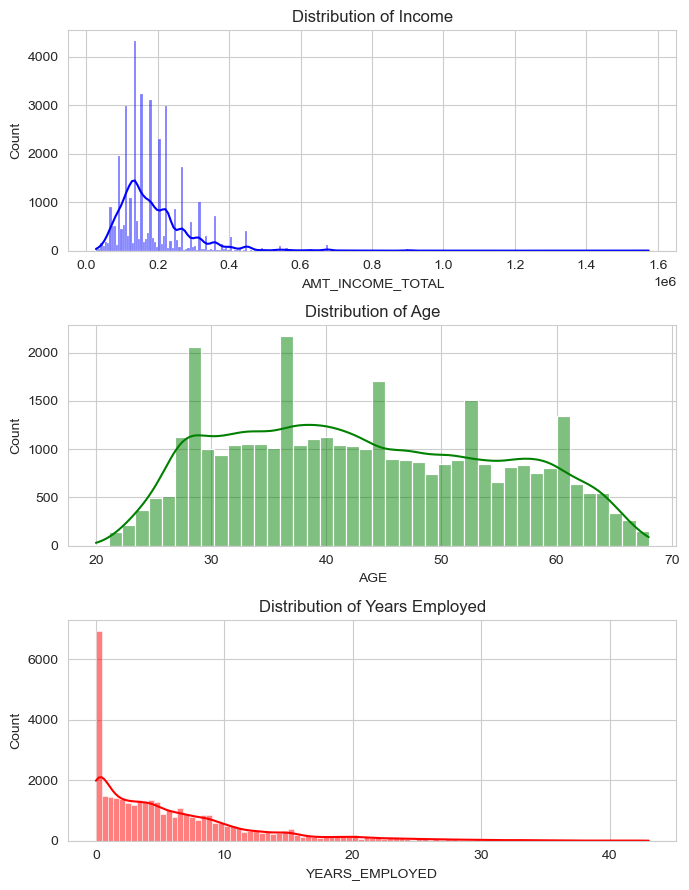

In [12]:
# Visualizing the distribution of key numerical features
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 9))

plot_data_histogram = [
    ('AMT_INCOME_TOTAL', 'blue', 'Distribution of Income'),
    ('AGE', 'green', 'Distribution of Age'),
    ('YEARS_EMPLOYED', 'red', 'Distribution of Years Employed')
]
for i, (column, color, title) in enumerate(plot_data_histogram):
    plot_histogram(final_df, column, axes[i], color, title)

plt.tight_layout()
plt.show()

**Income (AMT_INCOME_TOTAL):**

The distribution of income is right-skewed, indicating that most individuals have an income on the lower end of the scale. There are a few individuals with exceptionally high incomes which can be considered as outliers.

**Age (AGE):**

The age distribution is relatively uniform. This means we have a good representation of individuals from different age groups.

**Years Employed (YEARS_EMPLOYED):**

The distribution of years employed is also right-skewed. Most individuals have fewer years of employment (or pensioner), with a decline as the number of years increases. There are a few individuals with a very high number of employment years.

In [13]:
print(final_df['FLAG_MOBIL'].value_counts())

FLAG_MOBIL
1    36457
Name: count, dtype: int64


In [14]:
final_df = final_df.drop(columns=['FLAG_MOBIL'])

**DATA PREPROCESSING**

In [15]:
# Rename columns to be more descriptive
column_mapping = {
    "ID": "ID",
    "Credit_Risk": "Credit_Risk",
    "CODE_GENDER": "Gender",
    "FLAG_OWN_CAR": "Owns_Car",
    "FLAG_OWN_REALTY": "Owns_Property",
    "CNT_CHILDREN": "Number_of_Children",
    "AMT_INCOME_TOTAL": "Total_Income",
    "NAME_INCOME_TYPE": "Income_Type",
    "NAME_EDUCATION_TYPE": "Education_Level",
    "NAME_FAMILY_STATUS": "Family_Status",
    "NAME_HOUSING_TYPE": "Housing_Type",
    "FLAG_WORK_PHONE": "Has_Work_Phone",
    "FLAG_PHONE": "Has_Phone",
    "FLAG_EMAIL": "Has_Email",
    "OCCUPATION_TYPE": "Occupation",
    "CNT_FAM_MEMBERS": "Number_of_Family_Members",
    "AGE": "Age",
    "YEARS_EMPLOYED": "Years_Employed"
}

# Apply renaming
df_renamed = final_df.rename(columns=column_mapping)

# One-hot encode the categorical variables with drop_first option
df_encoded_drop_first = pd.get_dummies(df_renamed, columns=['Gender', 'Owns_Car', 'Owns_Property', 'Income_Type', 'Education_Level',
                                                           'Family_Status', 'Housing_Type', 'Occupation'], drop_first=True)
#df_encoded_drop_first.dtypes

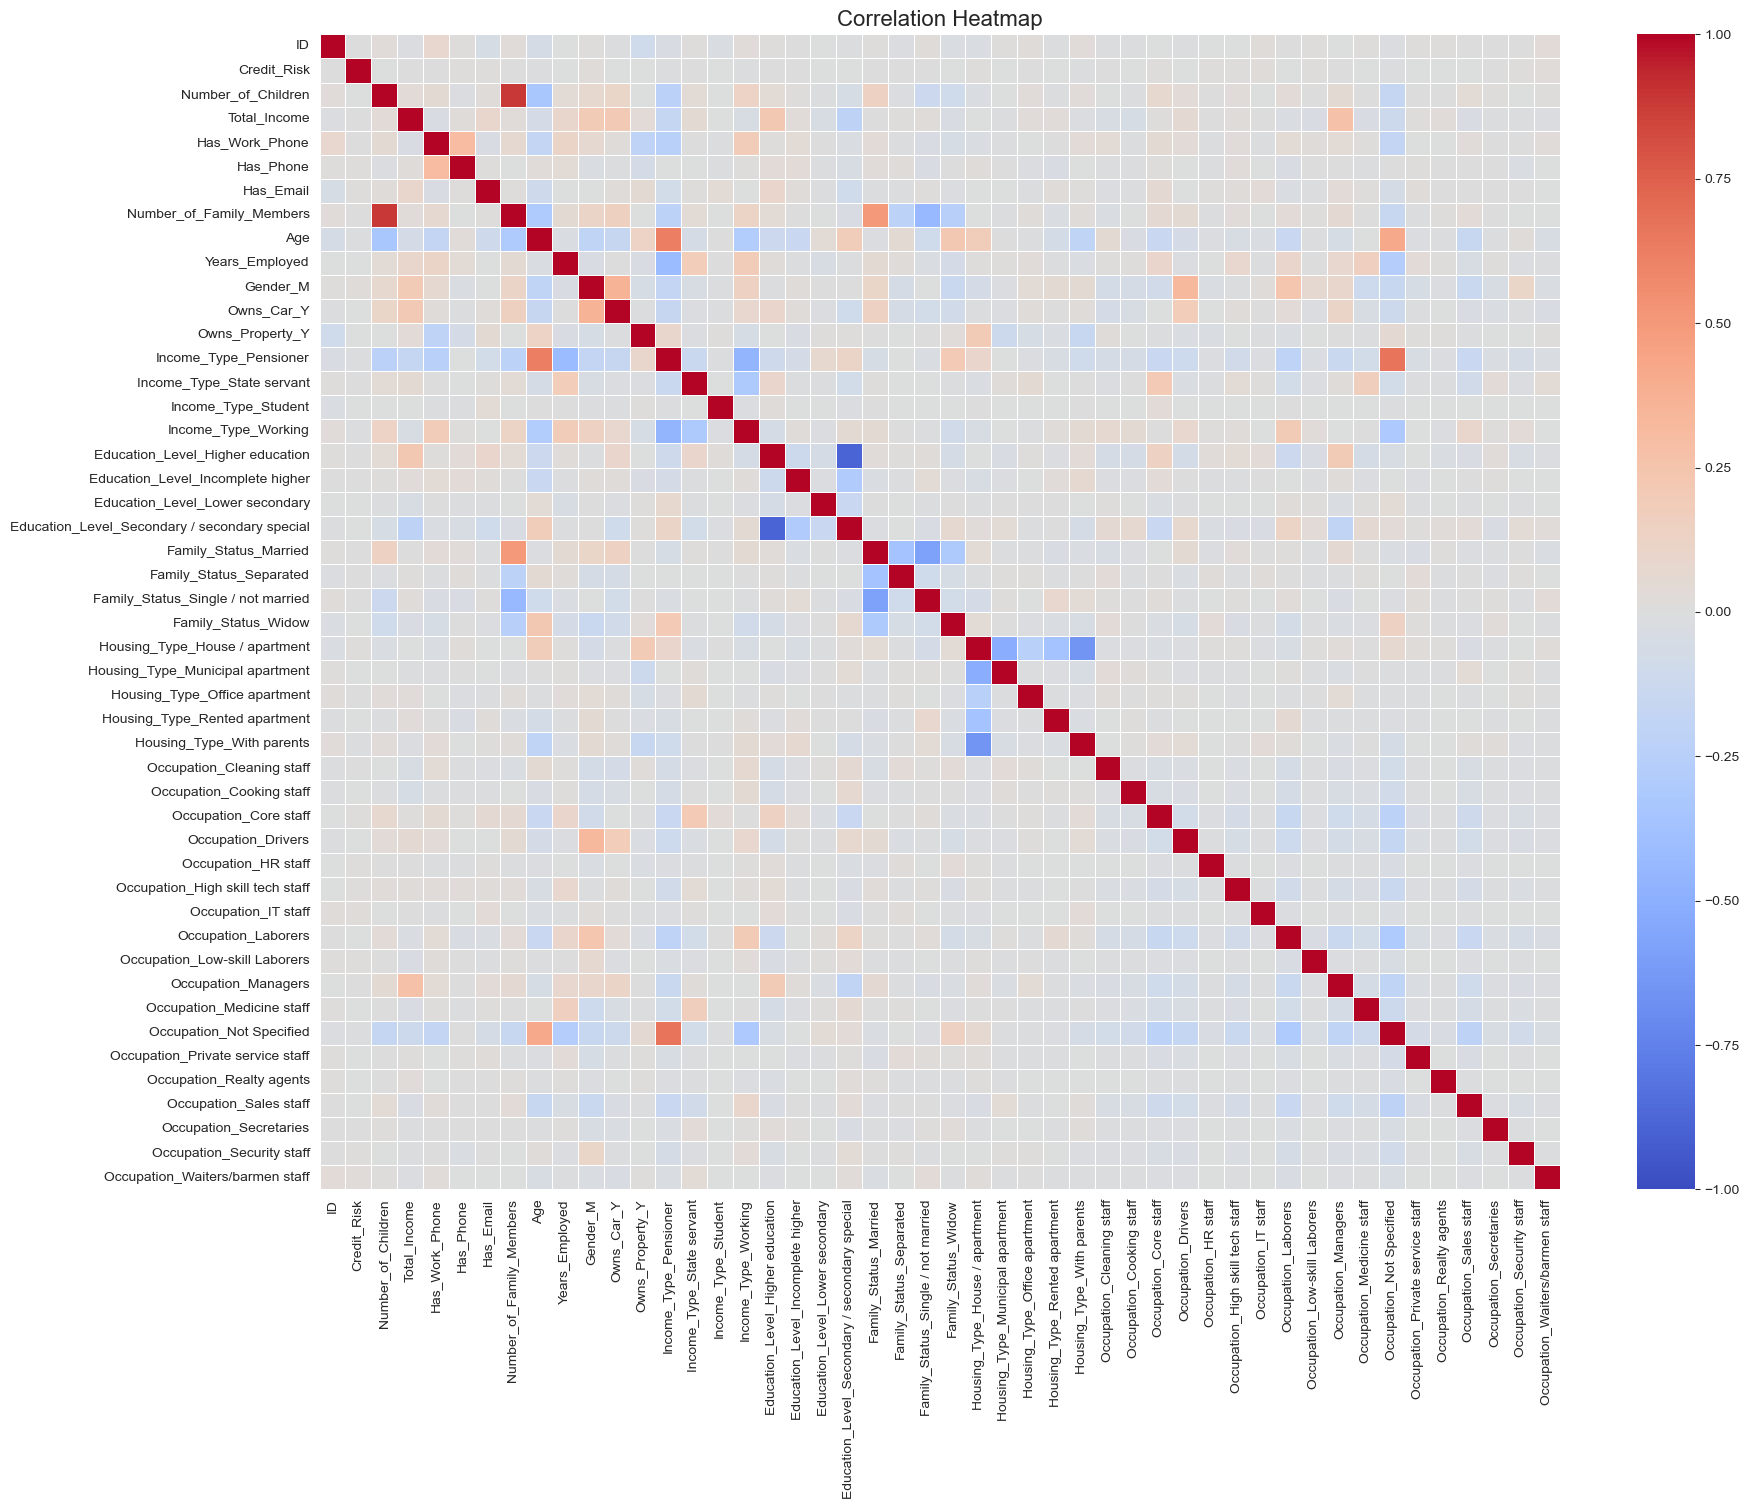

In [16]:
# Calculate the correlation matrix
corr_matrix = df_encoded_drop_first.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5, annot=False)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

**Credit_Risk and other variables:** The variable Credit_Risk has low or almost no correlation with most of the other variables. This suggests that the variables present may not be strong predictors of credit risk on their own.

**AGE and YEARS_EMPLOYED:** There is a moderate positive correlation (0.58) between age (AGE) and years of employment (YEARS_EMPLOYED). This makes sense, as older people tend to have more years of work experience.

**CNT_CHILDREN and CNT_FAM_MEMBERS:** There is a strong positive correlation (0.89) between the number of children (CNT_CHILDREN) and the number of family members (CNT_FAM_MEMBERS). This is logical since having more children directly increases the number of members in the family. So one of the two will be excluded. (Number_of_Children)

**AMT_INCOME_TOTAL and FLAG_WORK_PHONE:** There is a slight positive correlation between total income and the presence of a work phone. This might suggest that those who earn more are more likely to have a work phone, but the correlation is weak.

Correlation does not imply causation. Even if two variables are correlated, this does not necessarily mean that one causes the other.

In [17]:
df_final = df_encoded_drop_first.drop(columns=['ID', 'Number_of_Children'])

**MODEL TRAINING AND EVALUATION**

In [18]:
# Split the data into training, validation, and test sets
X = df_final.drop("Credit_Risk", axis=1)
y = df_final["Credit_Risk"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Identify numerical columns (assuming all numerical columns are of type float or int)
numerical_cols = X_train.select_dtypes(include=['float64', 'int64', 'int32']).columns

# Scale only numerical features
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train[numerical_cols])
X_val_numerical_scaled = scaler.transform(X_val[numerical_cols])
X_test_numerical_scaled = scaler.transform(X_test[numerical_cols])

# Combine scaled and non-scaled features
X_train_scaled = pd.concat([pd.DataFrame(X_train_numerical_scaled, columns=numerical_cols, index=X_train.index), 
                            X_train.drop(numerical_cols, axis=1)], axis=1).values
X_val_scaled = pd.concat([pd.DataFrame(X_val_numerical_scaled, columns=numerical_cols, index=X_val.index), 
                          X_val.drop(numerical_cols, axis=1)], axis=1).values
X_test_scaled = pd.concat([pd.DataFrame(X_test_numerical_scaled, columns=numerical_cols, index=X_test.index), 
                           X_test.drop(numerical_cols, axis=1)], axis=1).values

In [19]:
# Calculate the distribution of the target variable in each set
train_distribution = round(y_train.value_counts(normalize=True) * 100,2)
val_distribution = round(y_val.value_counts(normalize=True) * 100,2)
test_distribution = round(y_test.value_counts(normalize=True) * 100,2)

distributions = pd.DataFrame({
    'Training Set': train_distribution,
    'Validation Set': val_distribution,
    'Test Set': test_distribution
})

distributions

,Training Set,Validation Set,Test Set
Credit_Risk,,,
0,98.89,99.14,99.1
1,1.11,0.86,0.9


In [20]:
# Resampling strategies to handle data imbalance
resampling_strategies = {
    'Undersampling': RandomUnderSampler(random_state=42),
    'Oversampling': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42)
}

In [21]:
# Models and hyperparameters for grid search
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=42), {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'penalty': ['l2']
    }),
    'k-NN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }),
    'Naive Bayes': (GaussianNB(), {
        'var_smoothing': [1e-9, 1e-8, 1e-7]
    }),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }),
    'XGBoost': (XGBClassifier(random_state=42, eval_metric='logloss'), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1]
    })
}

Training Logistic Regression with Undersampling...


LogisticRegression(C=0.01, max_iter=1000, random_state=42)


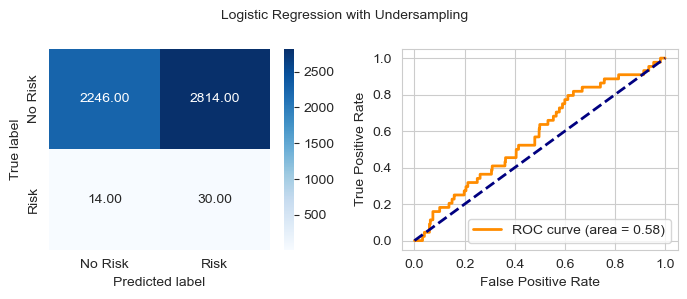

Training Logistic Regression with Oversampling...
LogisticRegression(C=10, max_iter=1000, random_state=42)


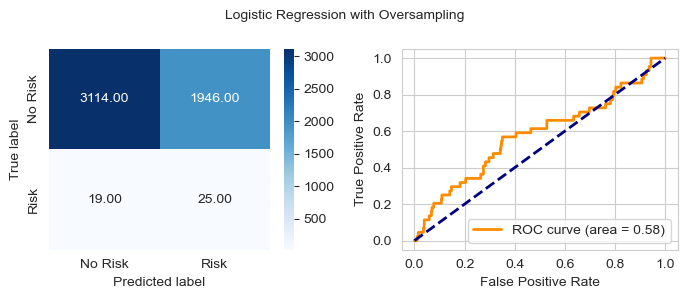

Training Logistic Regression with SMOTE...
LogisticRegression(C=0.01, max_iter=1000, random_state=42)


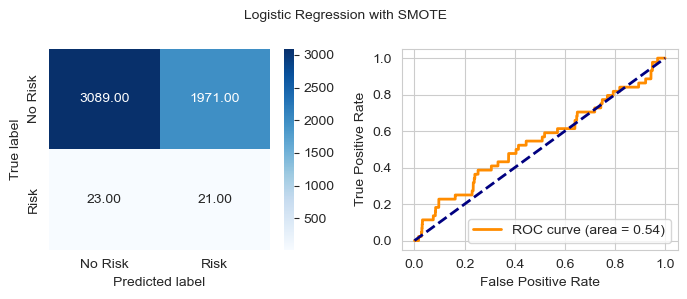

Training k-NN with Undersampling...
KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')


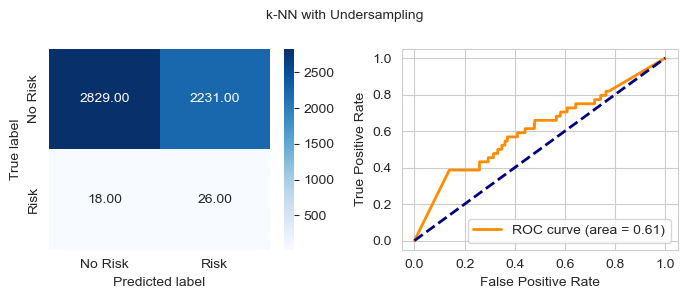

Training k-NN with Oversampling...
KNeighborsClassifier(metric='euclidean', weights='distance')


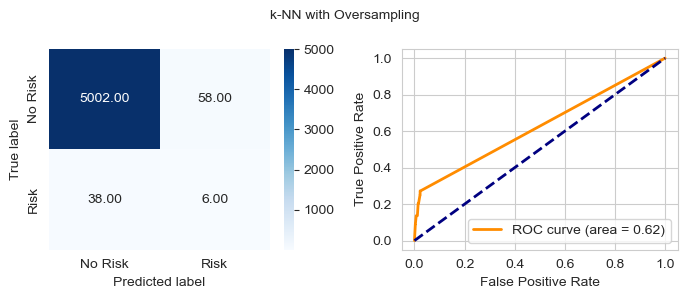

Training k-NN with SMOTE...
KNeighborsClassifier(metric='manhattan', weights='distance')


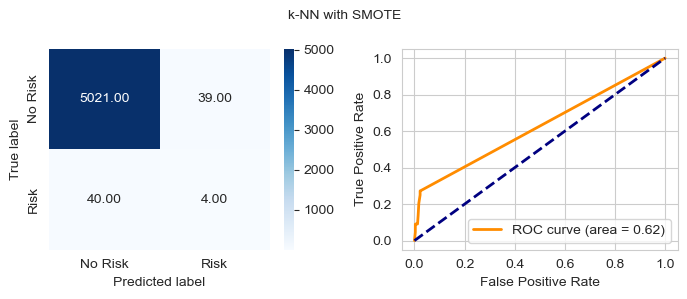

Training Naive Bayes with Undersampling...
GaussianNB(var_smoothing=1e-07)


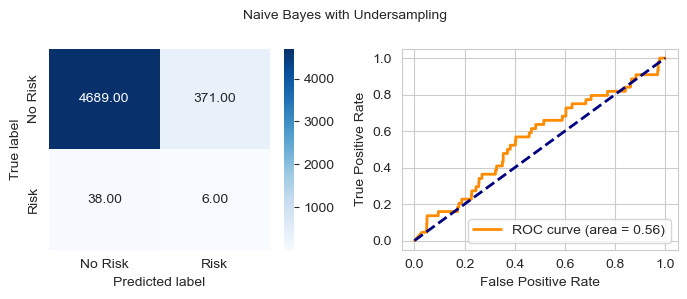

Training Naive Bayes with Oversampling...
GaussianNB(var_smoothing=1e-07)


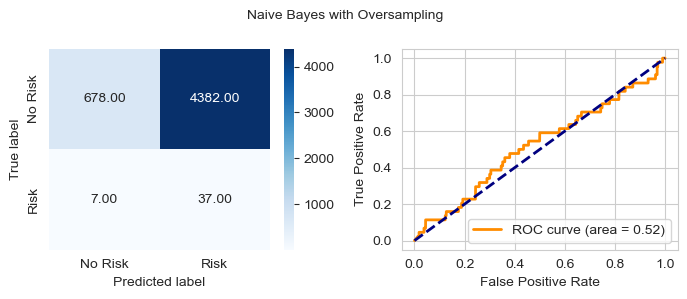

Training Naive Bayes with SMOTE...
GaussianNB()


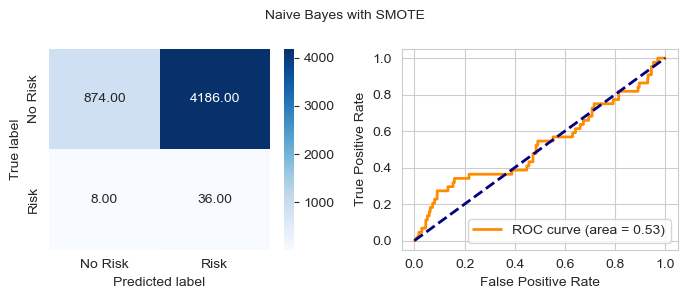

Training Decision Tree with Undersampling...
DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42)


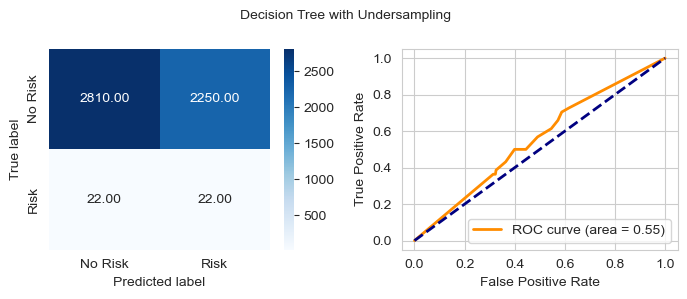

Training Decision Tree with Oversampling...
DecisionTreeClassifier(random_state=42)


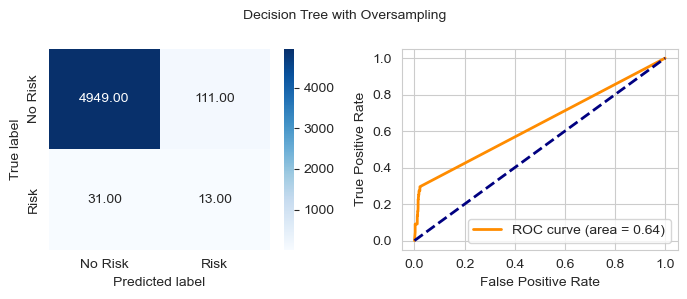

Training Decision Tree with SMOTE...
DecisionTreeClassifier(random_state=42)


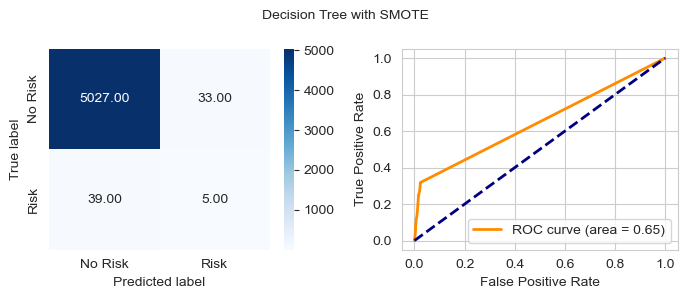

Training Random Forest with Undersampling...
RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       n_estimators=50, random_state=42)


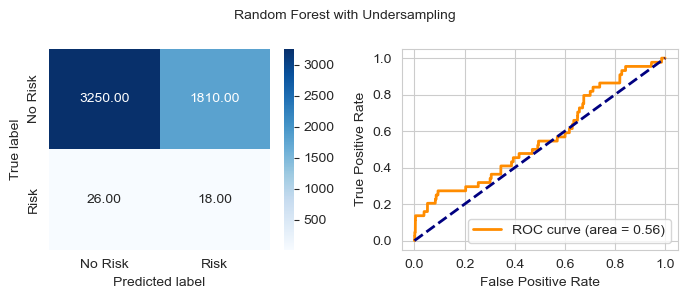

Training Random Forest with Oversampling...
RandomForestClassifier(n_estimators=50, random_state=42)


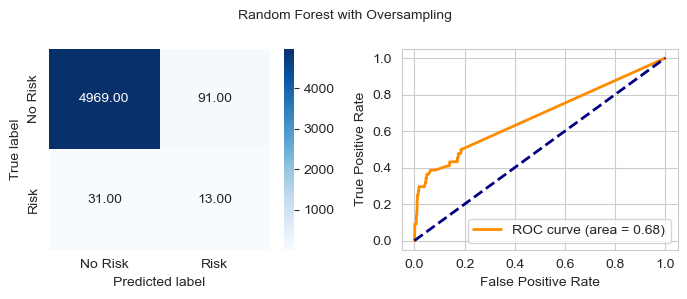

Training Random Forest with SMOTE...
RandomForestClassifier(min_samples_split=5, random_state=42)


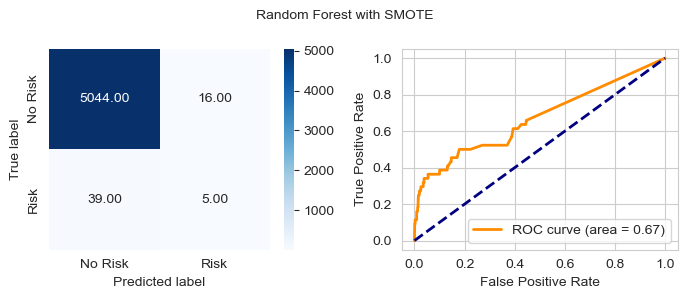

Training XGBoost with Undersampling...
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)


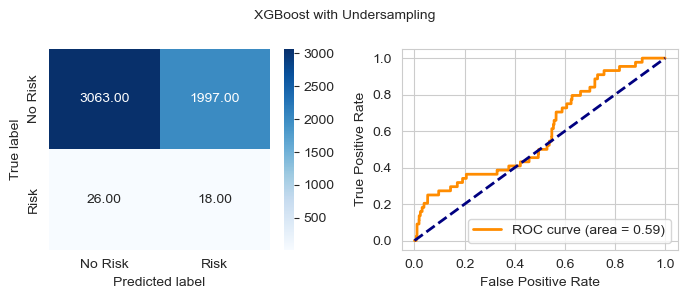

Training XGBoost with Oversampling...
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)


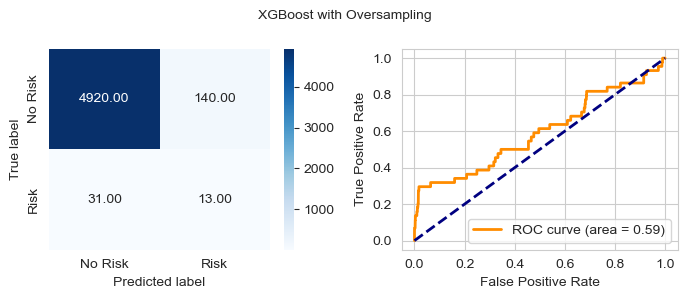

Training XGBoost with SMOTE...
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)


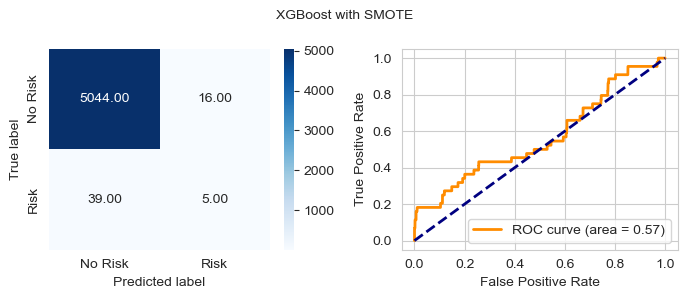

Accuracy  Recall  Precision  F1-Score  \
Logistic Regression Undersampling      0.45    0.68       0.01      0.02   
                    Oversampling       0.62    0.57       0.01      0.02   
                    SMOTE              0.61    0.48       0.01      0.02   
k-NN                Undersampling      0.56    0.59       0.01      0.02   
                    Oversampling       0.98    0.14       0.09      0.11   
                    SMOTE              0.98    0.09       0.09      0.09   
Naive Bayes         Undersampling      0.92    0.14       0.02      0.03   
                    Oversampling       0.14    0.84       0.01      0.02   
                    SMOTE              0.18    0.82       0.01      0.02   
Decision Tree       Undersampling      0.55    0.50       0.01      0.02   
                    Oversampling       0.97    0.30       0.10      0.15   
                    SMOTE              0.99    0.11       0.13      0.12   
Random Forest       Undersampling      0.64    0.41       0.01      0.02   
                    Oversampling       0.98    0.30       0.12      0.18   
                    SMOTE              0.99    0.11       0.24      0.15   
XGBoost             Undersampling      0.60    0.41       0.01      0.02   
                    Oversampling       0.97    0.30       0.08      0.13   
                    SMOTE              0.99    0.11       0.24      0.15   

                                   F2-Score  
Logistic Regression Undersampling      0.05  
                    Oversampling       0.06  
                    SMOTE              0.05  
k-NN                Undersampling      0.05  
                    Oversampling       0.12  
                    SMOTE              0.09  
Naive Bayes         Undersampling      0.05  
                    Oversampling       0.04  
                    SMOTE              0.04  
Decision Tree       Undersampling      0.04  
                    Oversampling       0.22  
                    SMOTE              0.12  
Random Forest       Undersampling      0.04  
                    Oversampling       0.23  
                    SMOTE              0.13  
XGBoost             Undersampling      0.04  
                    Oversampling       0.20  
                    SMOTE              0.13

In [22]:
results, best_model = train_and_evaluate(models, resampling_strategies, X_train_scaled, y_train, X_val_scaled, y_val)

# Display results
summary_table = pd.DataFrame({k: v['metrics'] for k, v in results.items()}).T
display(summary_table.round(2))

In [23]:
params = best_model.get_params()
for key, value in params.items():
    print(f"{key}: {value}")

bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 50
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


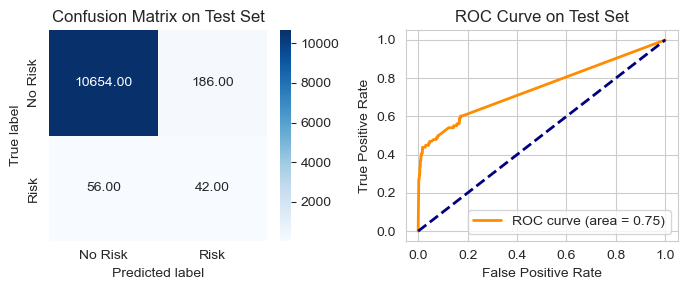

                        Accuracy  Recall  Precision  F1-Score  F2-Score
RandomForestClassifier      0.98    0.43       0.18      0.26      0.34


In [24]:

# Usage
metrics, y_test_pred, y_test_prob = evaluate_final_model(best_model, X_test_scaled, y_test)
plot_evaluation(y_test, y_test_pred, y_test_prob)

performance_table = pd.DataFrame(metrics, index=[best_model.__class__.__name__])
print(round(performance_table,2))

**ENSEMBLE LEARNING**

Given the performance metrics, using ensemble techniques (RandomForest-XGBoost and RandomForest-kNN) with the oversampling strategy could be a promising approach. The goal is to combine the strengths of different models and the advantages of a balanced dataset to obtain a model with balanced and robust performance metrics.

In [25]:
from sklearn.ensemble import VotingClassifier

# Model and parameters definitions
models_and_params = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1],
            'colsample_bytree': [0.8, 1]
        }
    },
    'k-NN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    }
}

# Resampling
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_scaled, y_train)

# Train individual models
best_models = train_models(models_and_params, X_train_resampled, y_train_resampled)

# Ensemble models
ensemble_rf_xgb = VotingClassifier(
    estimators=[('RandomForest', best_models['RandomForest']), ('XGBoost', best_models['XGBoost'])],
    voting='soft'
).fit(X_train_resampled, y_train_resampled)

ensemble_rf_knn = VotingClassifier(
    estimators=[('RandomForest', best_models['RandomForest']), ('k-NN', best_models['k-NN'])],
    voting='soft'
).fit(X_train_resampled, y_train_resampled)


# Evaluate ensemble on validation set
evaluate_and_print(ensemble_rf_xgb, X_val_scaled, y_val, "RF-XGBoost Ensemble")
evaluate_and_print(ensemble_rf_knn, X_val_scaled, y_val, "RF-kNN Ensemble")


Training RandomForest...
Training XGBoost...
Training k-NN...

Performance of RF-XGBoost Ensemble on Validation Set:
Accuracy: 0.9759
Precision: 0.1238
Recall: 0.2955
F1 Score: 0.1745
F2 Score: 0.2313

Performance of RF-kNN Ensemble on Validation Set:
Accuracy: 0.9743
Precision: 0.1150
Recall: 0.2955
F1 Score: 0.1656
F2 Score: 0.2249


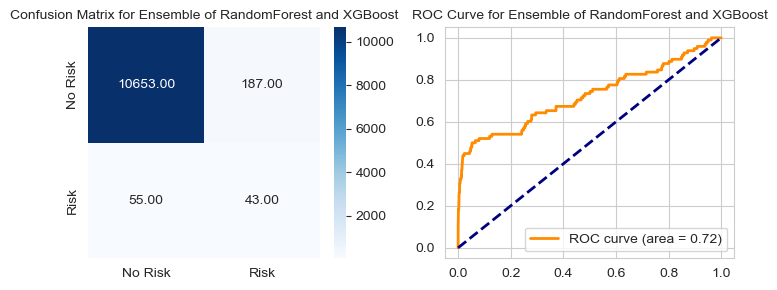

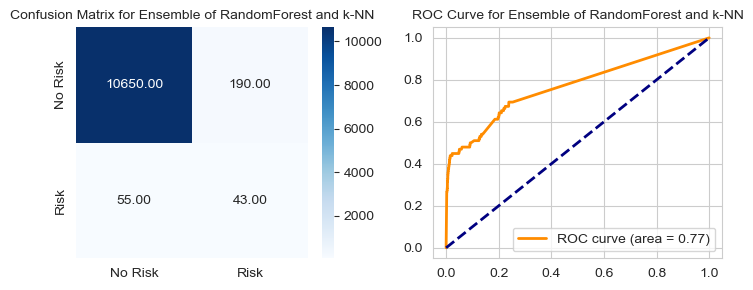

,Accuracy,Recall,Precision,F1-Score,F2-Score
RandomForestClassifier,0.98,0.43,0.18,0.26,0.34
Ensemble of RandomForest and XGBoost,0.98,0.44,0.19,0.26,0.35
Ensemble of RandomForest and k-NN,0.98,0.44,0.18,0.26,0.34


In [26]:
# Ensemble models in a dictionary
ensembles = {
    "Ensemble of RandomForest and XGBoost": ensemble_rf_xgb,
    "Ensemble of RandomForest and k-NN": ensemble_rf_knn
}

# Evaluate and visualize ensemble models
ensemble_results = evaluate_and_visualize_ensemble(ensembles, X_test_scaled, y_test)
combined_results = pd.concat([performance_table, ensemble_results])
display(combined_results.round(2))

**Recursive Feature Elimination - RFE**

Use RFE to maintain interpretability and understand the relative importance of model features. 
In our case it is particularly useful because we wish to maintain an interpretable relationship between features and output.

In [27]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

estimator = RandomForestClassifier(random_state=42)
selector = RFECV(estimator=estimator, step=1, cv=StratifiedKFold(3), scoring='f1')
selector = selector.fit(X_train_scaled, y_train)
selected_features = X.columns[selector.support_]
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_df = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)
X_train_selected = X_train_df[selected_features].values
X_val_selected = X_val_df[selected_features].values
X_test_selected = X_test_df[selected_features].values
print(f"Optimal number of features: {selector.n_features_}")
print("Selected features:", selected_features)

Optimal number of features: 6
Selected features: Index(['Total_Income', 'Number_of_Family_Members', 'Age', 'Years_Employed',
       'Owns_Car_Y', 'Owns_Property_Y'],
      dtype='object')


Training Logistic Regression with Undersampling...
LogisticRegression(C=0.01, max_iter=1000, random_state=42)


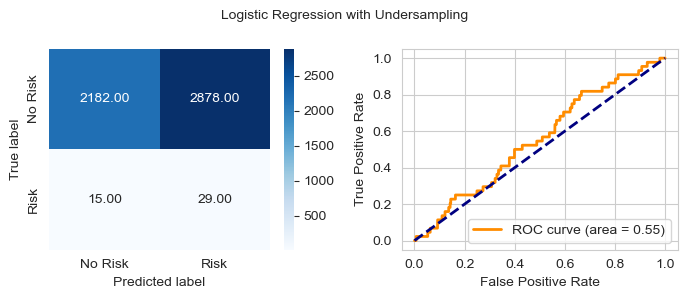

Training Logistic Regression with Oversampling...
LogisticRegression(C=0.001, max_iter=1000, random_state=42)


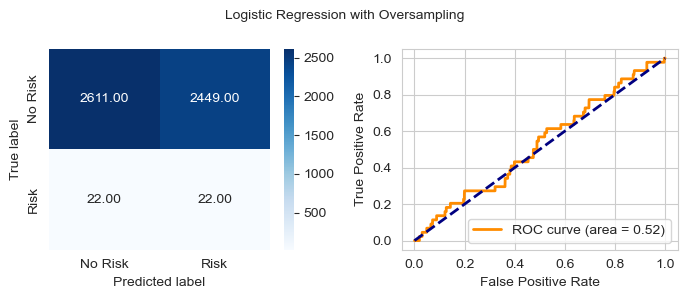

Training Logistic Regression with SMOTE...
LogisticRegression(C=0.1, max_iter=1000, random_state=42)


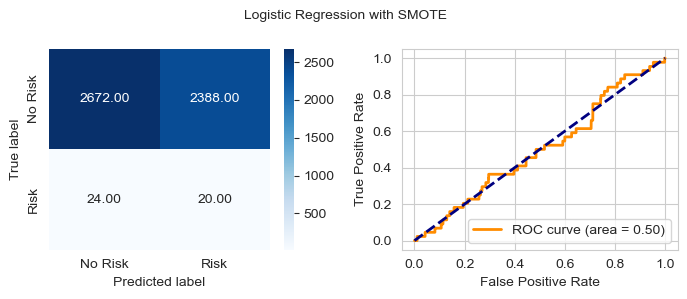

Training k-NN with Undersampling...
KNeighborsClassifier(metric='manhattan', weights='distance')


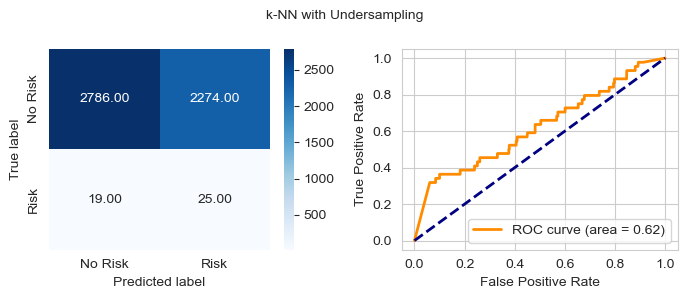

Training k-NN with Oversampling...
KNeighborsClassifier(metric='euclidean', weights='distance')


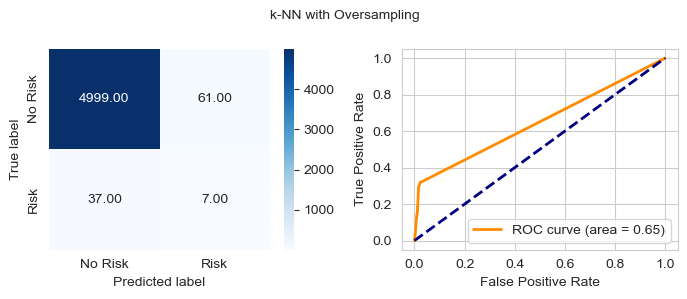

Training k-NN with SMOTE...
KNeighborsClassifier(metric='manhattan', weights='distance')


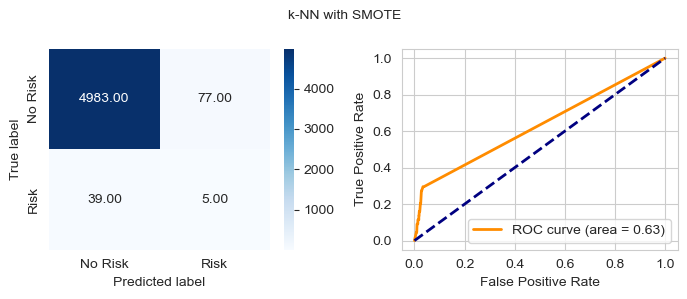

Training Naive Bayes with Undersampling...
GaussianNB()


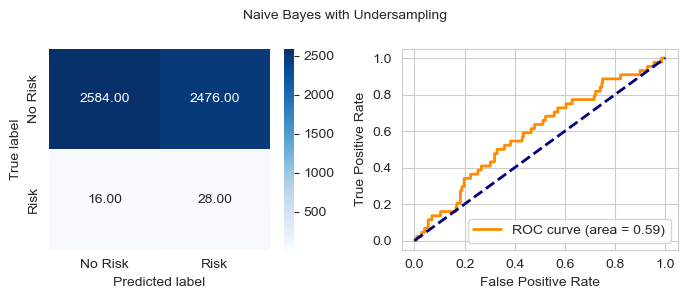

Training Naive Bayes with Oversampling...
GaussianNB()


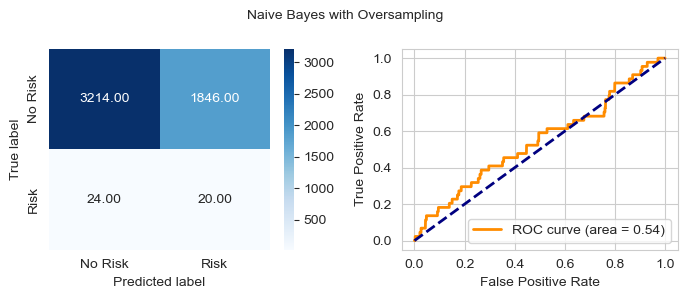

Training Naive Bayes with SMOTE...
GaussianNB()


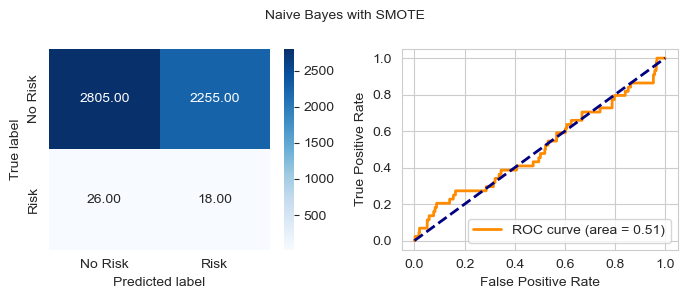

Training Decision Tree with Undersampling...
DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)


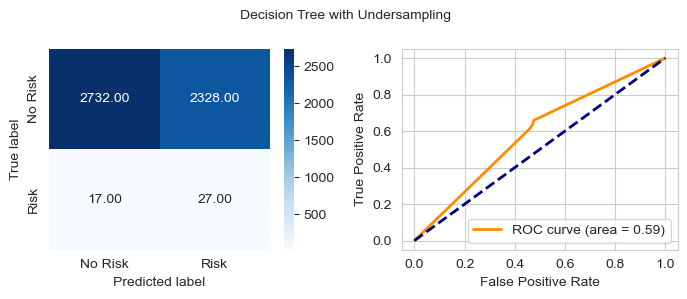

Training Decision Tree with Oversampling...
DecisionTreeClassifier(random_state=42)


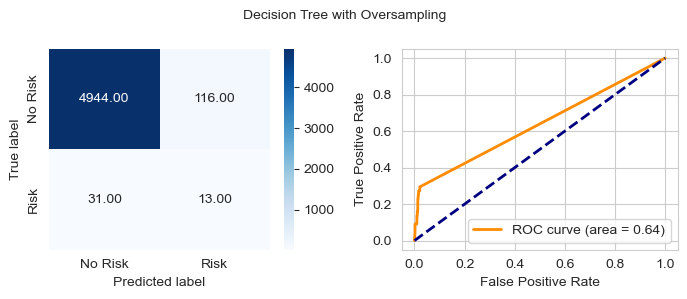

Training Decision Tree with SMOTE...
DecisionTreeClassifier(random_state=42)


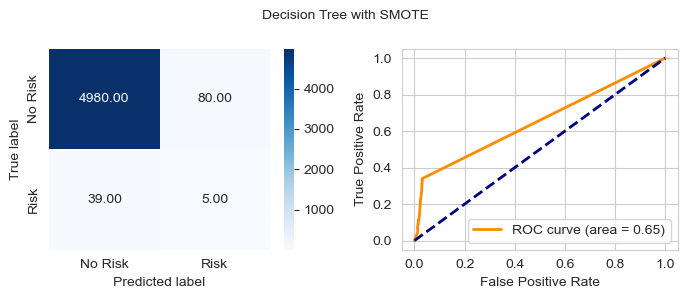

Training Random Forest with Undersampling...
RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200,
                       random_state=42)


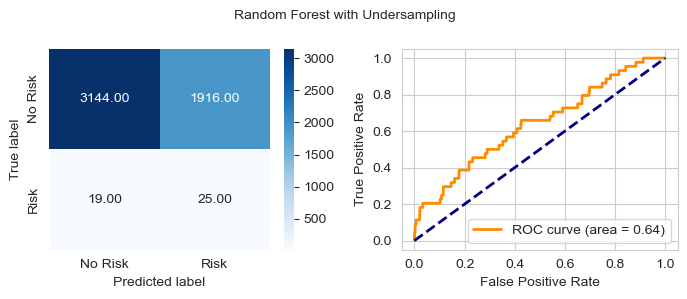

Training Random Forest with Oversampling...
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=200,
                       random_state=42)


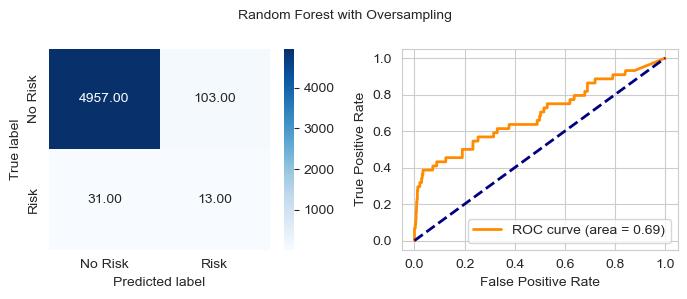

Training Random Forest with SMOTE...
RandomForestClassifier(min_samples_split=5, random_state=42)


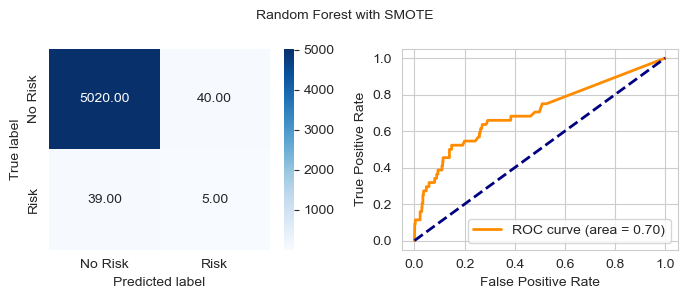

Training XGBoost with Undersampling...
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)


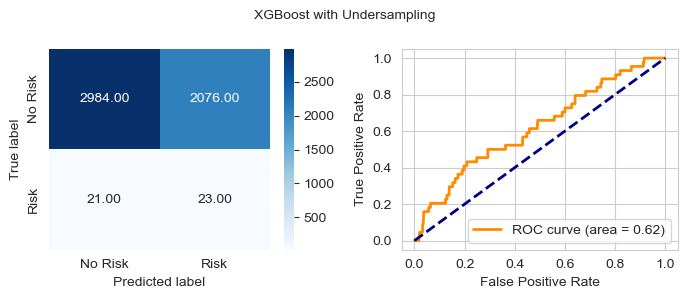

Training XGBoost with Oversampling...
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)


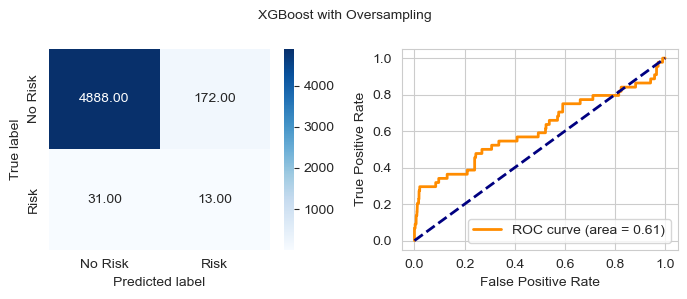

Training XGBoost with SMOTE...
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)


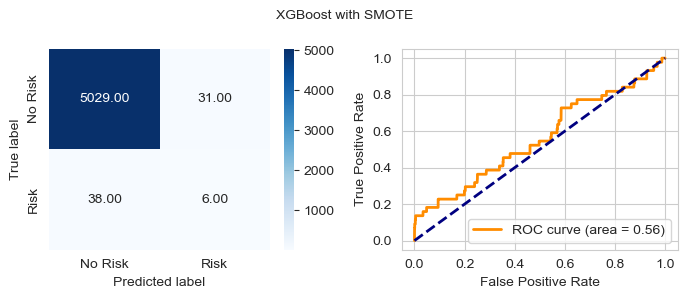

Accuracy  Recall  Precision  F1-Score  \
Logistic Regression Undersampling      0.43    0.66       0.01      0.02   
                    Oversampling       0.52    0.50       0.01      0.02   
                    SMOTE              0.53    0.45       0.01      0.02   
k-NN                Undersampling      0.55    0.57       0.01      0.02   
                    Oversampling       0.98    0.16       0.10      0.12   
                    SMOTE              0.98    0.11       0.06      0.08   
Naive Bayes         Undersampling      0.51    0.64       0.01      0.02   
                    Oversampling       0.63    0.45       0.01      0.02   
                    SMOTE              0.55    0.41       0.01      0.02   
Decision Tree       Undersampling      0.54    0.61       0.01      0.02   
                    Oversampling       0.97    0.30       0.10      0.15   
                    SMOTE              0.98    0.11       0.06      0.08   
Random Forest       Undersampling      0.62    0.57       0.01      0.03   
                    Oversampling       0.97    0.30       0.11      0.16   
                    SMOTE              0.98    0.11       0.11      0.11   
XGBoost             Undersampling      0.59    0.52       0.01      0.02   
                    Oversampling       0.96    0.30       0.07      0.11   
                    SMOTE              0.99    0.14       0.16      0.15   

                                   F2-Score  
Logistic Regression Undersampling      0.05  
                    Oversampling       0.04  
                    SMOTE              0.04  
k-NN                Undersampling      0.05  
                    Oversampling       0.14  
                    SMOTE              0.10  
Naive Bayes         Undersampling      0.05  
                    Oversampling       0.05  
                    SMOTE              0.04  
Decision Tree       Undersampling      0.05  
                    Oversampling       0.21  
                    SMOTE              0.10  
Random Forest       Undersampling      0.06  
                    Oversampling       0.22  
                    SMOTE              0.11  
XGBoost             Undersampling      0.05  
                    Oversampling       0.18  
                    SMOTE              0.14

In [28]:
# Dictionary to store results
results = {}

results, best_model_rfe = train_models_with_resampling(models, resampling_strategies, X_train_selected, y_train, X_val_selected, y_val)

# Display the summary table
summary_table = pd.DataFrame({k: v['metrics'] for k, v in results.items()}).T
display(summary_table.round(2))

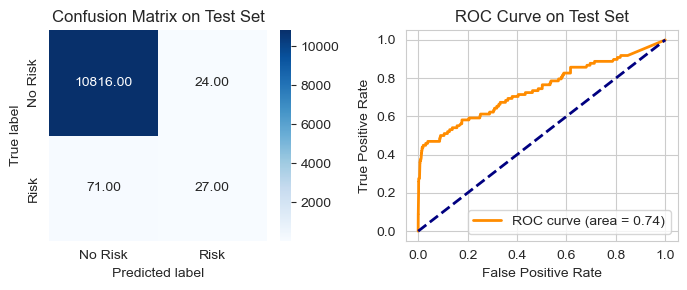

                              Accuracy  Recall  Precision  F1-Score  F2-Score
RFE - RandomForestClassifier      0.99    0.28       0.53      0.36       0.3


In [29]:
# Train the best model with selected features
best_model_rfe.fit(X_train_selected, y_train)
metrics, y_test_pred, y_test_prob = evaluate_final_model(best_model_rfe, X_test_selected, y_test)
plot_evaluation(y_test, y_test_pred, y_test_prob)

rfe_performance_table = pd.DataFrame(metrics, index=[f"RFE - {best_model_rfe.__class__.__name__}"])
print(round(rfe_performance_table, 2))

In [30]:
from sklearn.ensemble import VotingClassifier

# Model and parameters definitions
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

models_and_params = {
    'RandomForest': (RandomForestClassifier(random_state=42), rf_params),
    'XGBoost': (XGBClassifier(random_state=42, eval_metric='logloss'), xgb_params),
    'k-NN': (KNeighborsClassifier(), knn_params)
}

# Resampling
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_selected, y_train)

# Train individual models
best_models = train_single_models(models_and_params, X_train_resampled, y_train_resampled)

# Definizione delle configurazioni dell'ensemble
ensemble_configs = {
    'RF-XGBoost': ['RandomForest', 'XGBoost'],
    'RF-kNN': ['RandomForest', 'k-NN']
}

# Train and evaluate ensembles
trained_ensembles = train_and_evaluate_ensemble(best_models, ensemble_configs, X_train_resampled, y_train_resampled, X_val_selected, y_val)

ensemble_rf_xgb_rfe = trained_ensembles['RF-XGBoost']
ensemble_rf_knn_rfe = trained_ensembles['RF-kNN']

Training RandomForest...
Training XGBoost...
Training k-NN...

Performance of RF-XGBoost Ensemble on Validation Set:
Accuracy: 0.9736
Precision: 0.1111
Recall: 0.2955
F1 Score: 0.1615
F2 Score: 0.2218

Performance of RF-kNN Ensemble on Validation Set:
Accuracy: 0.9724
Precision: 0.1057
Recall: 0.2955
F1 Score: 0.1557
F2 Score: 0.2174


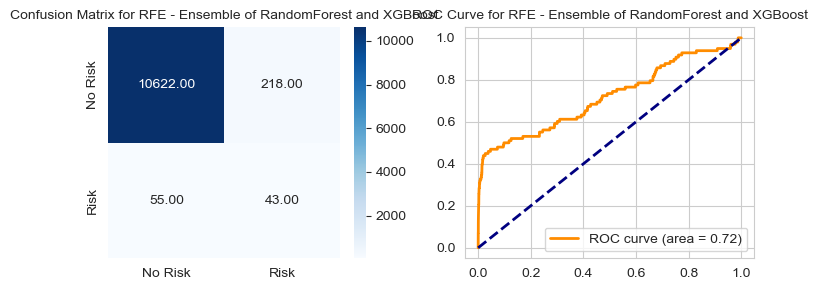

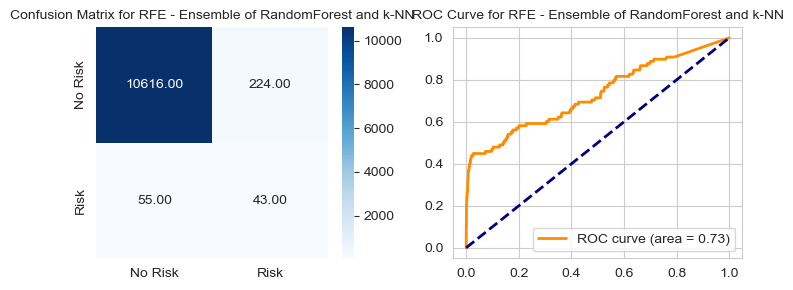

,Accuracy,Recall,Precision,F1-Score,F2-Score
RandomForestClassifier,0.98,0.43,0.18,0.26,0.34
Ensemble of RandomForest and XGBoost,0.98,0.44,0.19,0.26,0.35
Ensemble of RandomForest and k-NN,0.98,0.44,0.18,0.26,0.34
RFE - RandomForestClassifier,0.99,0.28,0.53,0.36,0.30
RFE - Ensemble of RandomForest and XGBoost,0.98,0.44,0.16,0.24,0.33
RFE - Ensemble of RandomForest and k-NN,0.97,0.44,0.16,0.24,0.33


In [31]:
# Evaluate and visualize ensemble models
ensemble_rf_xgb_metrics = evaluate_and_visualize_model(ensemble_rf_xgb_rfe, X_test_selected, y_test, "RFE - Ensemble of RandomForest and XGBoost")
ensemble_rf_knn_metrics = evaluate_and_visualize_model(ensemble_rf_knn_rfe, X_test_selected, y_test, "RFE - Ensemble of RandomForest and k-NN")

# Combine metrics into a single dataframe
all_metrics_df = pd.concat([combined_results, rfe_performance_table, ensemble_rf_xgb_metrics, ensemble_rf_knn_metrics])

# Display results
display(all_metrics_df.round(2))

Based on a balance between all these metrics, **Ensemble of RandomForest and XGB** seems to be the best choice. It has relatively high F1 and F2 scores, and even though its accuracy is not the highest, it is still comparable to the other models. Of course, as mentioned before, the choice of the best model also depends on the costs associated with false positives and false negatives.

**LIME (Local Interpretable Model-Agnostic Explanations)**

In [36]:
y_pred = ensemble_rf_xgb.predict(X_test_scaled)
true_positive_indices = np.where((y_test == 1) & (y_pred == 1))[0]
true_positive_index = true_positive_indices[5]

,Feature,Contribution
0,Occupation_IT staff = False,-0.046983
1,Housing_Type_With parents = False,0.033091
2,Income_Type_Pensioner = False,-0.026361
3,Gender_M = True,0.022749
4,Occupation_Realty agents = False,0.019603
5,Occupation_Drivers = False,0.019406
6,Years_Employed = 1.3753424657534246,0.018095
7,Occupation_Security staff = False,0.017437
8,Age = 26,0.014171
9,Occupation_Private service staff = False,0.012226


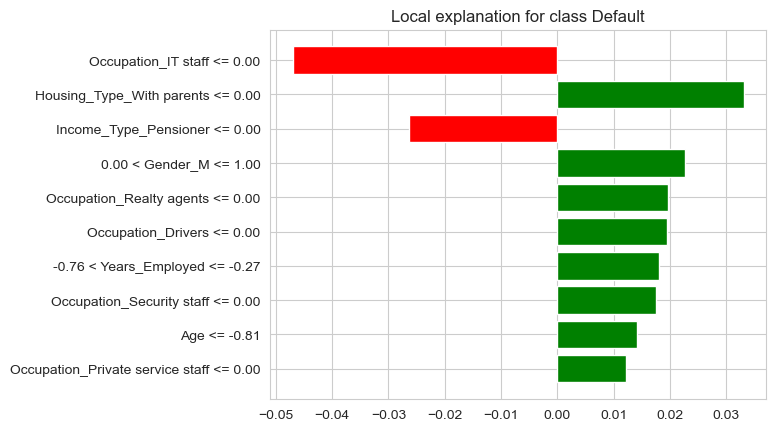

In [64]:
from lime.lime_tabular import LimeTabularExplainer

# Extracting the feature names
feature_names = X.columns.tolist()

# Create a LIME explainer for tabular data 
explainer = LimeTabularExplainer(X_train_scaled, 
                                 feature_names=feature_names, 
                                 class_names=['Not Default', 'Default'], 
                                 mode='classification', random_state=10)

# Explain a single prediction as an example
i = true_positive_index 

exp = explainer.explain_instance(X_test_scaled[i], ensemble_rf_xgb.predict_proba)
%matplotlib inline
fig = exp.as_pyplot_figure(label=1)
lime_df=pd.DataFrame(exp.as_list(),columns=['Feature','Contribution'])

for index, row in lime_df.iterrows():
    feature_info = row['Feature'].split(" <= ")[0]
    feature_name = find_best_match(feature_info, X_test.columns)
    
    if not feature_name:
        print(f"Feature {feature_info} not matched!")
        continue
    
    # Get the original value
    original_value = X_test.iloc[i][feature_name]
    
    # Replace the scaled value with the original value in the LIME dataframe
    lime_df.at[index, 'Feature'] = f"{feature_name} = {original_value}"
lime_df

Based on the output provided by LIME for a particular instance, here's an interpretation:

**Occupation_IT staff = False:** The fact that the individual is not an "IT staff" seems to have a notable negative influence on the model's prediction. It appears that IT staff might generally have a lower risk of default, suggesting that this occupation might generally be associated with better financial stability or reliability in the dataset.

**Occupation_Realty agents, Drivers, Security staff, and Private service staff = False:** Interestingly, not being associated with several specific occupations (like Realty agents, Drivers, Security staff, and Private service staff) increased the likelihood of the instance being classified as "Default". This could hint that people in these professions might be considered more financially stable or less risky, according to the model.

**Years_Employed = 1.375:** With approximately 1.375 years of employment, the model seems to perceive this tenure as a factor that increases the risk of default. It's possible that the model has learned from the data that individuals with shorter employment durations might face a higher risk of financial instability.

**Housing_Type_With parents = False:** Not living "With parents" is seen as a risk factor. This might suggest that individuals living with their parents could have a safety net, reducing their risk of default. Living independently might come with added financial responsibilities that could influence the ability to repay.

**Gender_M = True:** The gender being male has a positive contribution towards the default prediction. This suggests that, in the dataset, males might have a slightly higher likelihood of default compared to females. It's essential to approach such findings with caution, considering potential biases in the data.

**Age = 26:** The age of the individual, being 26, increases the likelihood of default slightly. This could hint at younger individuals potentially having a slightly higher risk, maybe due to less established credit history or financial experience.

**Income_Type_Pensioner = False:** Not being a pensioner decreases the chance of default. This might suggest that pensioners, or retired individuals, might generally have a more stable income source or fewer financial obligations, thus being less risky in terms of credit.

In summary, this instance's prediction is influenced by a combination of occupation, housing situation, income type, gender, and duration of employment. It's important to note that these interpretations are local to this particular instance and may not be generalized for the entire dataset. They provide insight into the model's reasoning for this specific prediction.
